In [25]:
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
import os
%matplotlib inline
os.environ['HOPSWORKS_API_KEY'] = 'cKV1tKzokpcwviY6.uP2qcFV2wWI8xxNu1I0UxyeqlRHqSEanLgKFjf5R1ypSy8A3AUnRkRpi0R9Gc5l0'

In [26]:
import hopsworks
import pandas as pd

In [27]:
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/196759
Connected. Call `.close()` to terminate connection gracefully.


In [28]:
wine_df = pd.read_csv("wine.csv")
wine_df
wine_df.duplicated().sum()

1168

In [29]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed_acidity         6487 non-null   float64
 2   volatile_acidity      6489 non-null   float64
 3   citric_acid           6494 non-null   float64
 4   residual_sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [30]:
wine_df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [31]:
wine_df['quality'].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

### Exploratory Data Analysis (EDA)  our Iris Data

Let's look at our iris flower - the distribution and range of values for the 4 different features
 * sepal_length
 * sepal_width
 * petal_length
 * petal_width
 
 and the target variable is `variety`.

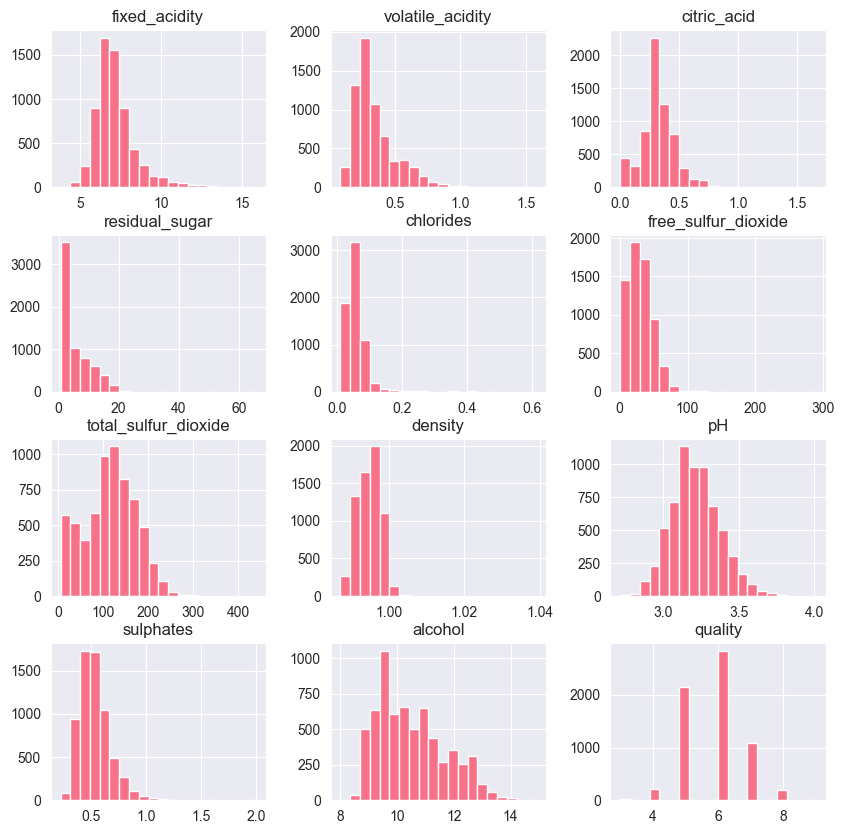

In [32]:
wine_df.hist(bins=20, figsize=(10, 10))
plt.show()

### Visualize range of values 
Here we can see the relation between the degree of alcohol and their quality. We can change the feature selected (here alcohol) to look for other relations.

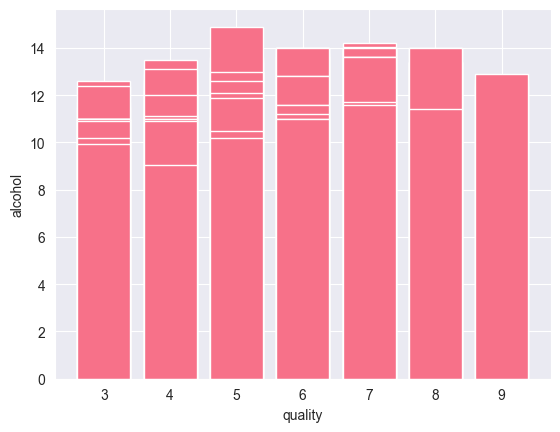

In [33]:
plt.bar(wine_df['quality'], wine_df['alcohol'])
plt.xlabel('quality')
plt.ylabel('alcohol')
plt.show()

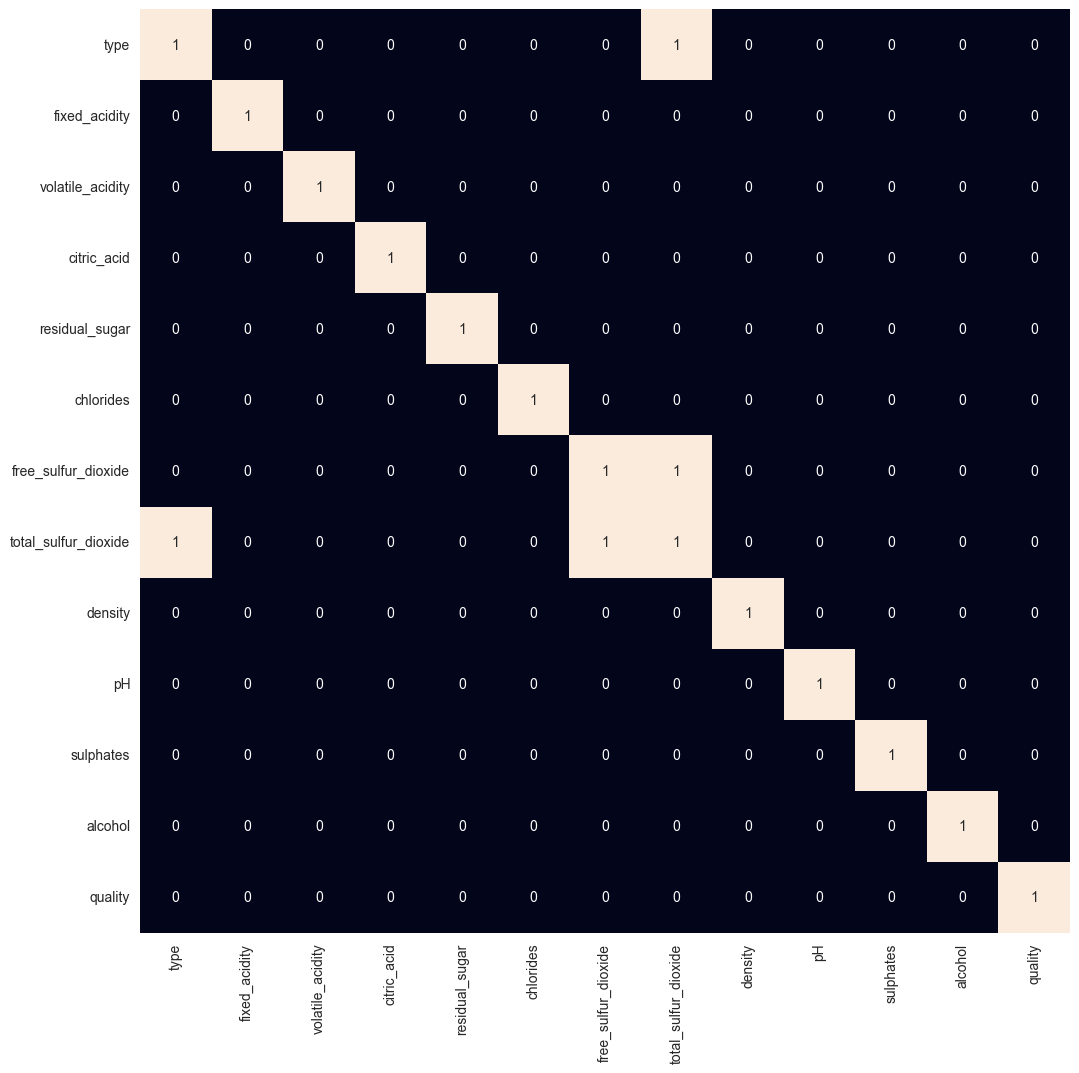

In [34]:
wine_df.replace({'white': 1, 'red': 0}, inplace=True)
plt.figure(figsize=(12, 12))
sns.heatmap(wine_df.corr() > 0.7, annot=True, cbar=False)
plt.show()

From the above heat map we can conclude that the "total sulphur dioxide" and "free sulphur dioxide" features are highly correlated features so, we will remove one of them.

In [36]:
wine_df = wine_df.drop('total_sulfur_dioxide', axis=1)

In [40]:
wine_fg = fs.get_or_create_feature_group(
    name="wine",
    version=1,
    primary_key=["type", "fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", "free_sulfur_dioxide", "density", "ph", "sulphates", "alcohol"],
    description="Wine quality dataset")
wine_fg.insert(wine_df)

Uploading Dataframe: 0.00% |          | Rows 0/6497 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: wine_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/196759/jobs/named/wine_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x19165606820>, None)

### Data Validation
If you want, you can enable data validation for your feature group.
The code below will prevent iris flower data from being written your your feature group if you write values outside the expected ranges.

In [41]:
from great_expectations.core import ExpectationSuite, ExpectationConfiguration

def expect(suite, column, min_val, max_val):
    suite.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={
            "column":column, 
            "min_value":min_val,
            "max_value":max_val,
        }
    )
)

In [43]:
suite = ExpectationSuite(expectation_suite_name="wine_dimensions")

expect(suite, "fixed_acidity", 3.8, 15.9)
expect(suite, "volatile_acidity", 0.08, 1.58)
expect(suite, "citric_acid", 0, 1.66)
expect(suite, "residual_sugar", 0.9, 65.8)
expect(suite, "chlorides", 0.009, 0.611)
expect(suite, "free_sulfur_dioxide", 1, 289)
expect(suite, "density", 0.98711, 1.2026)
expect(suite, "ph", 2.72, 4.01)
expect(suite, "sulphates", 0.22, 2)
expect(suite, "alcohol", 8, 14.9)
wine_fg.save_expectation_suite(expectation_suite=suite, validation_ingestion_policy="STRICT")

Attached expectation suite to Feature Group, edit it at https://c.app.hopsworks.ai:443/p/196759/fs/196678/fg/237972
